# Install yfinance

In [ ]:
!pip install yfinance

# Import Libralies





In [73]:
import numpy as np
import pandas as pd

import yfinance as yf

import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Forecasting ETH from Yahoo Finance with LSTM

In [75]:

# Etherium price historical
eth = yf.Ticker('ETH-USD')

data = eth.history(start="2015-07-01",  end="2020-01-01", auto_adjust=True)

data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-08-07,2.831620,3.536610,2.521120,2.772120,164329,0,0
2015-08-08,2.793760,2.798810,0.714725,0.753325,674188,0,0
2015-08-09,0.706136,0.879810,0.629191,0.701897,532170,0,0
2015-08-10,0.713989,0.729854,0.636546,0.708448,405283,0,0
2015-08-11,0.708087,1.131410,0.663235,1.067860,1463100,0,0
...,...,...,...,...,...,...,...
2019-12-28,127.213013,130.258163,126.899696,128.322708,8069298610,0,0
2019-12-29,128.266876,136.811203,127.997658,134.757980,9708776786,0,0
2019-12-30,134.796524,136.757355,131.545563,132.633484,9796951716,0,0


# Data Exploration

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1609 entries, 2015-08-07 to 2020-01-01
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1609 non-null   float64
 1   High          1609 non-null   float64
 2   Low           1609 non-null   float64
 3   Close         1609 non-null   float64
 4   Volume        1609 non-null   int64  
 5   Dividends     1609 non-null   int64  
 6   Stock Splits  1609 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 100.6 KB


Text(0.5, 1.0, 'ETH-USD price')

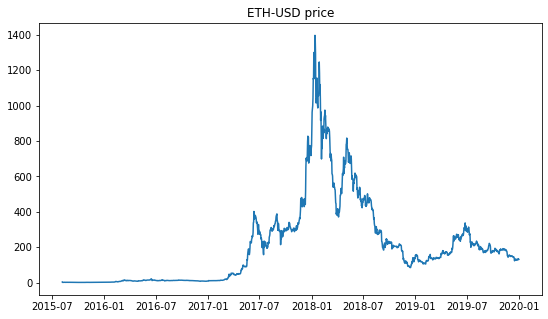

In [81]:
plt.figure(figsize=(9, 5))
plt.plot(data["Close"])
plt.title("ETH-USD price")

# Preprocessing

In [60]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [82]:
scaled_data

array([[0.00167429],
       [0.00022815],
       [0.00019131],
       ...,
       [0.09469918],
       [0.09253395],
       [0.09338722]])

In [61]:
# how many days do i want to base my predictions on ?
prediction_days = 30

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build LSTM Model

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. Introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network.

In [62]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

# Training

In [63]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 30, 50)            10400     
                                                                 
 dropout_9 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(x_train, 
          y_train, 
          epochs=25, 
          batch_size = 32,
          callbacks = [checkpointer])

# Predictions

In [65]:
# test model accuracy on existing data

test_data = eth.history(start="2021-01-01",  end= dt.datetime.now(), auto_adjust=True)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [66]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

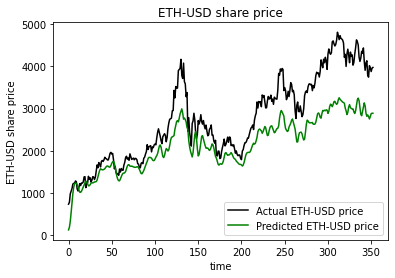

<Figure size 648x360 with 0 Axes>

In [86]:
plt.plot(actual_prices, color='black', label=f"Actual ETH-USD price")
plt.plot(predicted_prices, color= 'green', label=f"Predicted ETH-USD price")
plt.title(f"ETH-USD share price")
plt.xlabel("time")
plt.ylabel(f"ETH-USD share price")
plt.legend()
plt.figure(figsize=(9, 5))
plt.show()

In [72]:
rsme = np.sqrt(np.mean(predicted_prices - actual_prices)**2)
rsme

587.7757710789148